In [1]:
# Load data - run prep_exp.ipynb first
import pickle

pickle_in = open("temp.pkl","rb")
data = pickle.load(pickle_in)

# # If it's not there, do the following:
# import sys
# import os
# import numpy as np
# from str2bool import str2bool
# from rpy2.robjects.packages import STAP
# import rpy2.robjects as robjects
# from rpy2.robjects import pandas2ri, numpy2ri
# from rpy2.robjects.lib.dplyr import DataFrame
# from rpy2.robjects.packages import importr

# pandas2ri.activate()
# numpy2ri.activate()

# # Some temporary arguments for testing
# include_lab = str2bool("T")  # Include lab features?
# include_ethdon = str2bool("T")  # Include ethnicity + donor details?
# lag = int("1")  # Number of lag variables
# eq_train_ratio = str2bool("T")  # Train on equal case:control ratio?
# __file__ = '/h/angeliney/projects/SRTR/prep_exp.py'
# visit_type = "first"
# output = "temp"
# post2000 = True

# # Get features based on these inputs
# with open(os.path.join(os.path.dirname(__file__), 'features.R'), 'r') as f:
#     string = f.read()
# features_file = STAP(string, "features")
# features_to_use = features_file.features.rx2("clin")
# if include_lab:
#     features_to_use = features_to_use + features_file.features.rx2("lab")

# if include_ethdon:
#     features_to_use = features_to_use + features_file.features.rx2("eth") + features_file.features.rx2("don")

# timedep_cols = np.intersect1d(features_to_use, features_file.timedep_features)
# cov_cols = np.setdiff1d(features_to_use, timedep_cols)

# if eq_train_ratio:
#     eq_cases_train_cols = np.array(["TRR_ID", "is_diab"])
# else:
#     eq_cases_train_cols = np.array()
    
# # Read RDS files (load data table)
# readRDS = robjects.r['readRDS']
# tx_li_study = readRDS(os.path.join(os.path.dirname(__file__), 'tx_li_formatted.rds'))
# txf_li_study = readRDS(os.path.join(os.path.dirname(__file__), 'txf_li_formatted.rds'))

# # Merge them
# with open(os.path.join(os.path.dirname(__file__), 'functions.R'), 'r') as f:
#     string = f.read()
# functions = STAP(string, "functions")

# merged = functions.combine_tx_txf(tx_li_study, txf_li_study, np.setdiff1d(cov_cols, "age"), timedep_cols, lag)

# df = pandas2ri.ri2py_dataframe(DataFrame(merged).filter('time_next_followup > time_since_transplant'))

# #Prep data for model training
# cols = np.concatenate((timedep_cols, cov_cols))
# if lag > 0:
#     for l in range(1,  lag + 1):
#         cols = np.append(cols, list(map(lambda x: '{}_{}'.format(x, l), timedep_cols)))

# subset_cols = np.concatenate((['transplant_year', 'TRR_ID', 'age'], cols, ['is_diab', 'time_since_transplant',
#                                                                    'time_next_followup', 'time_to_diab',
#                                                                    'diab_time_since_tx', 'diab_in_1_year',
#                                                                    'diab_now']))
# df = df.dropna(subset=subset_cols)
# df_test = df[(df.transplant_year.astype(int) >= 2011) & (df.time_to_diab >= 0)]
# df_nontest = df[(df.transplant_year.astype(int) < 2011) & (df.time_to_diab >= 0)]

# num_folds = 5
# nontest_y = df_nontest.drop_duplicates(subset=['TRR_ID', 'is_diab']).is_diab
# caret = importr('caret')
# folds = caret.createFolds(nontest_y, num_folds, False)

# data = {'test': df_test, 'train': df_nontest, 'cols': cols, 'eq_cases_train_cols': eq_cases_train_cols,
#             'folds': folds}

# import pickle

# # Save data in case kernel got restarted
# pickle.dump(data, open("temp.pkl", "wb")) 

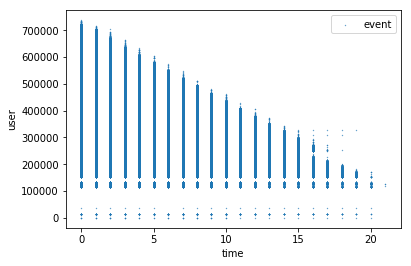

In [2]:
# Prep data
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy as np


df = pandas.concat([data['train'], data['test']])

# Modify time_since_transplant to accommodate for 0.5 value
def mod_time(x):
    from math import ceil  
    if x == 0:
        return -1
    elif x == 0.5:
        return 0
    elif x % 1 > 0:
        return ceil(x) # To prevent collapse with visit time from beforehand, always round up
    else:
        return x

    
df['time2'] = df.time_since_transplant.apply(mod_time)

# This is different than time since transplant since some people miss albumin, bilirubin, creatinine or acute rej episode at time of transplant
df['t_elapsed'] = df.groupby('TRR_ID', group_keys=False).apply(lambda g : g.time2 - g.time2.min())
df.t_elapsed = df.t_elapsed.astype(int)

# Plot events
plt.scatter(df.t_elapsed, df.TRR_ID, 0.1, label='event')
plt.xlabel('time')
plt.ylabel('user')
plt.legend()


In [3]:
# Subset train, val, test
nontest_ids = data['train'].drop_duplicates(subset=['TRR_ID', 'is_diab']).TRR_ID

i=1
train_ids = nontest_ids[np.array(data['folds']) != i]
val_ids = np.setdiff1d(nontest_ids, train_ids)

train = df[df.TRR_ID.isin(train_ids)]
val = df[df.TRR_ID.isin(val_ids)] 
test = df[df.TRR_ID.isin(data['test'].TRR_ID)] 

In [4]:
# These are from wtte.transforms but changed, because there's a bug in their versions: id was not ordered 
# and the seq_lengths in df_to_array are not in the same order as unique_ids
def df_to_padded(df, column_names, id_col='id', t_col='t', max_seq_len=None):
    """Pads pandas df to a numpy array of shape `[n_seqs,max_seqlen,n_features]`.
        see `df_to_array` for details
    """
    return df_to_array(df, column_names, nanpad_right=True, id_col=id_col, t_col=t_col, max_seq_len=max_seq_len)


def df_to_array(df, column_names, nanpad_right=True, id_col='id', t_col='t', max_seq_len=None):
    """Converts flat pandas df with cols `id,t,col1,col2,..` to array indexed `[id,t,col]`. 
    :param df: dataframe with columns:
      * `id`: Any type. A unique key for the sequence.
      * `t`: integer. If `t` is a non-contiguous int vec per id then steps in
        between t's are padded with zeros.
      * `columns` in `column_names` (String list)
    :type df: Pandas dataframe
    :param Boolean nanpad_right: If `True`, sequences are `np.nan`-padded to `max_seq_len`
    :param return_lists: Put every tensor in its own subarray
    :param id_col: string column name for `id`
    :param t_col: string column name for `t`
    :return padded: With seqlen the max value of `t` per id
      a numpy float array of dimension `[n_seqs,max_seqlen,n_features]`
    """

    # Do not sort. Create a view.
    grouped = df.groupby(id_col, sort=False)

    unique_ids = list(grouped.groups.keys())

    n_seqs = grouped.ngroups
    n_features = len(column_names)
    seq_lengths = df[[id_col, t_col]].groupby(id_col, as_index=False).aggregate('max')
    seq_lengths[t_col] = seq_lengths[t_col] + 1
    
    # We can't assume to fit varying length seqs. in flat array without
    # padding.
    assert nanpad_right or seq_lengths.shape[0] == 1, 'Wont fit in flat array'
    
    if not max_seq_len:
        max_seq_len = seq_lengths[t_col].values.max()

    # Initialize the array to be filled
    padded = np.zeros([n_seqs, max_seq_len, n_features])

    # Fill it
    for s in xrange(n_seqs):
        # df_user is a view
        df_group = grouped.get_group(unique_ids[s]).query("{} <= {}".format(t_col, max_seq_len))
        
        padded[s][df_group[t_col].values, :] = df_group[column_names].values
        
        seq_len = seq_lengths[seq_lengths[id_col] == unique_ids[s]][t_col].values[0]
        if nanpad_right and seq_len < max_seq_len:
            padded[s][seq_len:, :].fill(np.nan)

    return padded, unique_ids


In [34]:
x_train, id_train = df_to_padded(df=train, column_names=data['cols'], id_col='TRR_ID', t_col='t_elapsed')
x_val, id_val = df_to_padded(df=val, column_names=data['cols'], id_col='TRR_ID', t_col='t_elapsed', 
                     max_seq_len = x_train.shape[1])
x_test, id_test = df_to_padded(df=test, column_names=data['cols'], id_col='TRR_ID', t_col='t_elapsed',
                     max_seq_len = x_train.shape[1])

In [44]:
import glob, os, sys, time

sys.path.append('./theanomodels/')
from utils.misc import getConfigFile, readPickle, displayTime


sys.path.append('./dmm/')
from   dmm.model_th.dmm import DMM
import dmm.model_th.learning as DMM_learn
import dmm.model_th.evaluate as DMM_evaluate

mask_value = 0
x_train_masked = x_train.copy()
x_train_masked[np.isnan(x_train_masked)] = mask_value
x_val_masked = x_val.copy()
x_val_masked[np.isnan(x_val_masked)] = mask_value
x_test_masked = x_test.copy()
x_test_masked[np.isnan(x_test_masked)] = mask_value

dataset = {
    'dim_observations' : data['cols'].shape[0],
    'data_type' : 'real',
    'train' : {'tensor': x_train_masked, 'mask': np.logical_not(np.isnan(x_train[:,:,0])), 'id': id_train},
    'valid' : {'tensor': x_val_masked, 'mask': np.logical_not(np.isnan(x_val[:,:,0])), 'id': id_val},
    'test' : {'tensor': x_test_masked, 'mask': np.logical_not(np.isnan(x_test[:,:,0])), 'id': id_test},
}


In [38]:
max_visits = x_train.shape[1]
params = {
    'dim_observations' : dataset['dim_observations'],
    'data_type' : dataset['data_type'],
    'dataset' : 'srtr',
    'epochs' : 10,
    'seed' : 1,
    'init_weight' : 0.1,
    'dim_stochastic' : 2,
    'expt_name' : 'something',
    'reg_value' : 0.05,
    'reloadFile' : './NOSUCHFILE',
    'reg_spec' : '_',
    'dim_hidden' : max_visits,
    'lr' : 0.0008,
    'reg_type' : 'l2',
    'init_scheme' : 'uniform',
    'optimizer' : 'adam',
    'use_generative_prior' : 'approx',
    'maxout_stride' : 4,
    'batch_size' : 512,
    'savedir' : './chkpt',
    'forget_bias' : -5.0,
    'inference_model' : 'R',
    'emission_layers' : 2,
    'savefreq' : 10,
    'rnn_cell' : 'lstm',
    'rnn_size' : max_visits,
    'paramFile' : './NOSUCHFILE',
    'nonlinearity' : 'relu',
    'rnn_dropout' : 0.1,
    'transition_layers' : 2,
    'anneal_rate' : 2.0,
    'debug' : False,
    'validate_only' : False,
    'transition_type' : 'mlp',
    'unique_id' : 'dmm_results2',
    'leaky_param' : 0.0
}

#Create a temporary directory to save checkpoints
os.system('mkdir -p '+params['savedir'])

#Specify the file where `params` corresponding for this choice of model and data will be saved
pfile= params['savedir']+'/'+params['unique_id']+'-config.pkl'

print 'Checkpoint prefix: ', pfile
dmm  = DMM(params, paramFile = pfile)


Checkpoint prefix:  ./chkpt/dmm_results2-config.pkl
	<<Sampling biases for LSTM from exponential distribution>>
	<<Nparameters: 10000>>
	<<WARNING: lr will not differentiated with respect to>>
	<<WARNING: anneal will not differentiated with respect to>>
	<<WARNING: update_ctr will not differentiated with respect to>>
	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.1>>
	<<In _LSTM_RNN_layer with dropout 0.1000>>
	<<Modifying : [q_W_input_0,q_b_input_0,W_lstm_r,b_lstm_r,U_lstm_r,q_W_st,q_b_st,q_W_mu,q_b_mu,q_W_cov,q_b_cov,p_trans_W_0,p_trans_b_0,p_trans_W_1,p_trans_b_1,p_trans_W_mu,p_trans_b_mu,p_trans_W_cov,p_trans_b_cov,p_emis_W_0,p_emis_b_0,p_emis_W_1,p_emis_b_1,p_emis_W_out,p_emis_b_out]>>
<< Reg:(l2) Reg. Val:(0.05) Reg. Spec.:(_)>>
<<<<<< Adding l2 regularization for q_W_input_0 >>>>>>
<<<<<< Adding l2 regularization for q_b_input_0 >>>>>>
<<<<<< Adding l2 regularization for W_lstm_r >>>>>>
<<<<<< Adding l2 regularization for b_lstm_r >>>>>>
<<<<<< Adding l2 re